In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [5]:
X_train = pd.read_csv('C:/Users/ptoma/AppData/Roaming/JetBrains/PyCharm2023.3/scratches/X_train.csv')

X_train = X_train.drop(columns="Id")
X_train = X_train.loc[~(X_train == 0).all("columns")].reset_index(drop=True)

In [6]:
simulation_start = X_train.index[X_train["t"] == 0].tolist() #remover as linhas onde todos os valores são zero (colisões)
#print("simulation_start:", simulation_start)



In [7]:
# Criar as simulações com os slices de X_train
simulations = [X_train.iloc[simulation_start[i]:simulation_start[i + 1]] for i in range(len(simulation_start) - 1)]

# Verificar se simulations não está vazio e se contém DataFrames válidos
print("Número de simulações:", len(simulations))



Número de simulações: 4997


In [8]:
# Concatenar as simulações
if simulations:
    simulations_concat = pd.concat(simulations, keys=range(len(simulations)), names=["simulation", "index"])

# Resetar o índice sem remover a coluna 'simulation'
simulations_concat = simulations_concat.reset_index()  # Isso manterá 'simulation' como coluna

# Agora você pode criar 'trajectory_id'
simulations_concat['trajectory_id'] = simulations_concat['simulation']  # Copiar os valores 

# Remover a coluna 'simulation' se não for mais necessária
simulations_concat = simulations_concat.drop(columns=['simulation'])

# Verificar o resultado
print(simulations_concat[0:15])



    index         t       x_1       y_1     v_x_1     v_y_1       x_2  \
0       0  0.000000  1.000000  0.000000  0.000000  0.000000 -0.266467   
1       1  0.039062  0.999548  0.000092 -0.023159  0.004731 -0.266261   
2       2  0.078125  0.998190  0.000370 -0.046362  0.009474 -0.265641   
3       3  0.117188  0.995925  0.000833 -0.069654  0.014239 -0.264606   
4       4  0.156250  0.992747  0.001483 -0.093080  0.019040 -0.263154   
5       5  0.195312  0.988650  0.002321 -0.116689  0.023888 -0.261282   
6       6  0.234375  0.983627  0.003350 -0.140528  0.028797 -0.258985   
7       7  0.273438  0.977668  0.004572 -0.164650  0.033779 -0.256258   
8       8  0.312500  0.970760  0.005990 -0.189111  0.038851 -0.253095   
9       9  0.351562  0.962888  0.007608 -0.213969  0.044027 -0.249488   
10     10  0.390625  0.954037  0.009431 -0.239288  0.049327 -0.245427   
11     11  0.429688  0.944187  0.011464 -0.265141  0.054769 -0.240904   
12     12  0.468750  0.933315  0.013712 -0.291604  

In [48]:
# Primeiro, obtemos os IDs únicos de trajetória
trajectory_ids = simulations_concat['trajectory_id'].unique()

# Dividir trajetórias em treino e o resto (validação + teste)
train_val_ids, test_ids = train_test_split(trajectory_ids, test_size=0.15, random_state=0)

# Dividir o resto em validação e teste
train_ids, val_ids = train_test_split(train_val_ids, test_size=0.15, random_state=0)

# Agora, criamos os conjuntos baseados nos IDs das trajetórias
train_set = simulations_concat[simulations_concat['trajectory_id'].isin(train_ids)].reset_index(drop=True)
val_set = simulations_concat[simulations_concat['trajectory_id'].isin(val_ids)].reset_index(drop=True)
test_set = simulations_concat[simulations_concat['trajectory_id'].isin(test_ids)].reset_index(drop=True)

train_set = train_set.sample(frac=1, random_state=42).reset_index(drop=True)
test_set = test_set.sample(frac=1, random_state=42).reset_index(drop=True)
val_set = val_set.sample(frac=1, random_state=42).reset_index(drop=True)




In [49]:
# Agora, repetindo o mesmo processo para val_set
# 5. Extrair features e a coluna de tempo para `val_x`
def prepare_data(df, drop_columns=["t", "trajectory_id", "index"], time_column="t"):
    """
    Prepara os dados para o conjunto de validação, treinamento ou teste.

    Args:
        df (pd.DataFrame): O DataFrame contendo os dados.
        drop_columns (list): Lista de colunas a serem removidas do DataFrame.
        time_column (str): O nome da coluna de tempo.

    Returns:
        pd.DataFrame: DataFrame preparado com as posições iniciais constantes e a coluna de tempo.
    """

    # 1. Remover colunas indesejadas e redefinir o índice
    features_df = df.drop(columns=drop_columns).reset_index(drop=True)
    t_df = pd.DataFrame({time_column: df[time_column].values}).reset_index(drop=True)

    # 2. Repetir as posições iniciais para cada simulação
    initial_positions = features_df.iloc[0].values  # Posições iniciais constantes
    num_samples = len(df)  # Número total de linhas no DataFrame

    # 3. Criar um DataFrame com as posições iniciais repetidas
    constant_positions_df = pd.DataFrame(np.tile(initial_positions, (num_samples, 1)), columns=features_df.columns)

    # 4. Combinar os DataFrames para formar `val_x`
    prepared_data = pd.concat([constant_positions_df.reset_index(drop=True), t_df.reset_index(drop=True)], axis=1)

    return prepared_data


# Exemplo de uso:
train_x = prepare_data(train_set)
val_x = prepare_data(val_set)
test_x = prepare_data(test_set)








print("\nval_x head:")
print(val_x.head())


val_x head:
        x_1       y_1     v_x_1     v_y_1       x_2       y_2     v_x_2  \
0  0.269941  0.321855  0.473975  0.286644 -0.000417 -0.067827 -1.985065   
1  0.269941  0.321855  0.473975  0.286644 -0.000417 -0.067827 -1.985065   
2  0.269941  0.321855  0.473975  0.286644 -0.000417 -0.067827 -1.985065   
3  0.269941  0.321855  0.473975  0.286644 -0.000417 -0.067827 -1.985065   
4  0.269941  0.321855  0.473975  0.286644 -0.000417 -0.067827 -1.985065   

     v_y_2       x_3       y_3     v_x_3     v_y_3        t  
0 -0.93384 -0.269524 -0.254028  1.511091  0.647195  6.87500  
1 -0.93384 -0.269524 -0.254028  1.511091  0.647195  2.03125  
2 -0.93384 -0.269524 -0.254028  1.511091  0.647195  5.42969  
3 -0.93384 -0.269524 -0.254028  1.511091  0.647195  2.14844  
4 -0.93384 -0.269524 -0.254028  1.511091  0.647195  0.15625  


In [50]:
train_y = train_set.drop(columns=["t", "trajectory_id","index",]).reset_index(drop=True)
val_y = val_set.drop(columns=["t", "trajectory_id","index"]).reset_index(drop=True)
test_y = test_set.drop(columns=["t", "trajectory_id","index"]).reset_index(drop=True)

print(train_y.head())


        x_1       y_1     v_x_1     v_y_1       x_2       y_2     v_x_2  \
0 -0.821788 -1.742613 -0.514979  0.283561 -1.300508 -1.386662  0.451273   
1  0.101092 -0.727824  1.932559  0.767870  0.261324 -0.654357 -1.813379   
2 -0.614897 -0.958768 -1.346645 -1.699774 -0.707467 -0.798395  0.234880   
3 -0.188924  1.223259  0.070632  0.627320 -0.104741 -0.575946  0.456598   
4 -0.076979 -1.014721 -0.133464  1.732857 -0.276388 -1.000431  0.028753   

      v_y_2       x_3       y_3     v_x_3     v_y_3  
0 -0.381507  2.122296  3.129275  0.063705  0.097946  
1 -1.187364 -0.362416  1.382180 -0.119179  0.419495  
2  0.116148  1.322364  1.757164  1.111765  1.583626  
3 -1.173292  0.293665 -0.647314 -0.527230  0.545973  
4 -1.688598  0.353367  2.015153  0.104712 -0.044259  


In [51]:
baseline = Pipeline([
    ('scaler', StandardScaler()),  
    ('regressor', LinearRegression())  
])

baseline.fit(train_x,train_y)



Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor', LinearRegression())])

In [52]:
# 6. Fazer previsões no conjunto de validação
val_predictions = baseline.predict(val_x)

# 7. Avaliar o erro (MSE)
mse = mean_squared_error(val_y, val_predictions)
rmse=np.sqrt(mse)
print(f" Root Mean Squared Error : {rmse}")

 Root Mean Squared Error : 1.1895617031637067


In [53]:
#Testar o baseline model no conjunto de teste

test_predictions=baseline.predict(test_x)

mse = mean_squared_error(test_y, test_predictions)
rmse=np.sqrt(mse)
print(f" Root Mean Squared Error : {rmse}")

 Root Mean Squared Error : 1.1773185729308713


In [16]:
from sklearn.linear_model import RidgeCV

def validate_poly_regression(train_x, val_x, train_y, val_y,test_x,test_y, regressor=None, degrees=range(1, 5)):
    best_model = None
    best_rmse = float('inf') 

    # Loop através dos graus especificados para a regressão polinomial
    for degree in degrees:
        # Criar um pipeline com características polinomiais e o regressor
        
        alphas = [0.1, 1.0, 10.0, 100.0]
        pipeline = Pipeline([
            ('scaler', StandardScaler()),  # Escalonamento dos dados
            ('poly_features', PolynomialFeatures(degree=degree, include_bias=False)),  # Adicionando características polinomiais
            ('regressor', RidgeCV(alphas=alphas))  # validação cruzada
        ])

        # Ajustar o modelo nos dados de treinamento amostrados
        pipeline.fit(train_x, train_y)

        # Imprimir o número de características geradas
        #poly_features = pipeline.named_steps['polynomialfeatures']
        #print(f'Degree: {degree}, Number of features generated: {poly_features.n_output_features_}')
        
        # Prever no conjunto de validação
        y_val_pred = pipeline.predict(val_x)
        y_test_pred=pipeline.predict(test_x)

        # Calcular o RMSE
        val_rmse = np.sqrt(mean_squared_error(val_y, y_val_pred))
        print(f'Val RMSE: {val_rmse}')
        
        test_rmse = np.sqrt(mean_squared_error(test_y, y_test_pred))
        print(f'Test RMSE: {test_rmse}')

        # Verificar se este modelo é o melhor até agora
        if test_rmse < best_rmse:
            best_rmse = test_rmse
            best_model = pipeline

    return best_model, best_rmse

In [ ]:
# Amostrar 1% dos dados de treinamento
#train_x_sample = train_x.sample(frac=0.01, random_state=0)  # Amostra 1% de train_set
#train_y_sample = train_y.loc[train_x_sample.index].reset_index(drop=True) 

#best_model, best_rmse = validate_poly_regression(train_x_sample, val_x, train_y_sample, val_y, test_x,test_y)

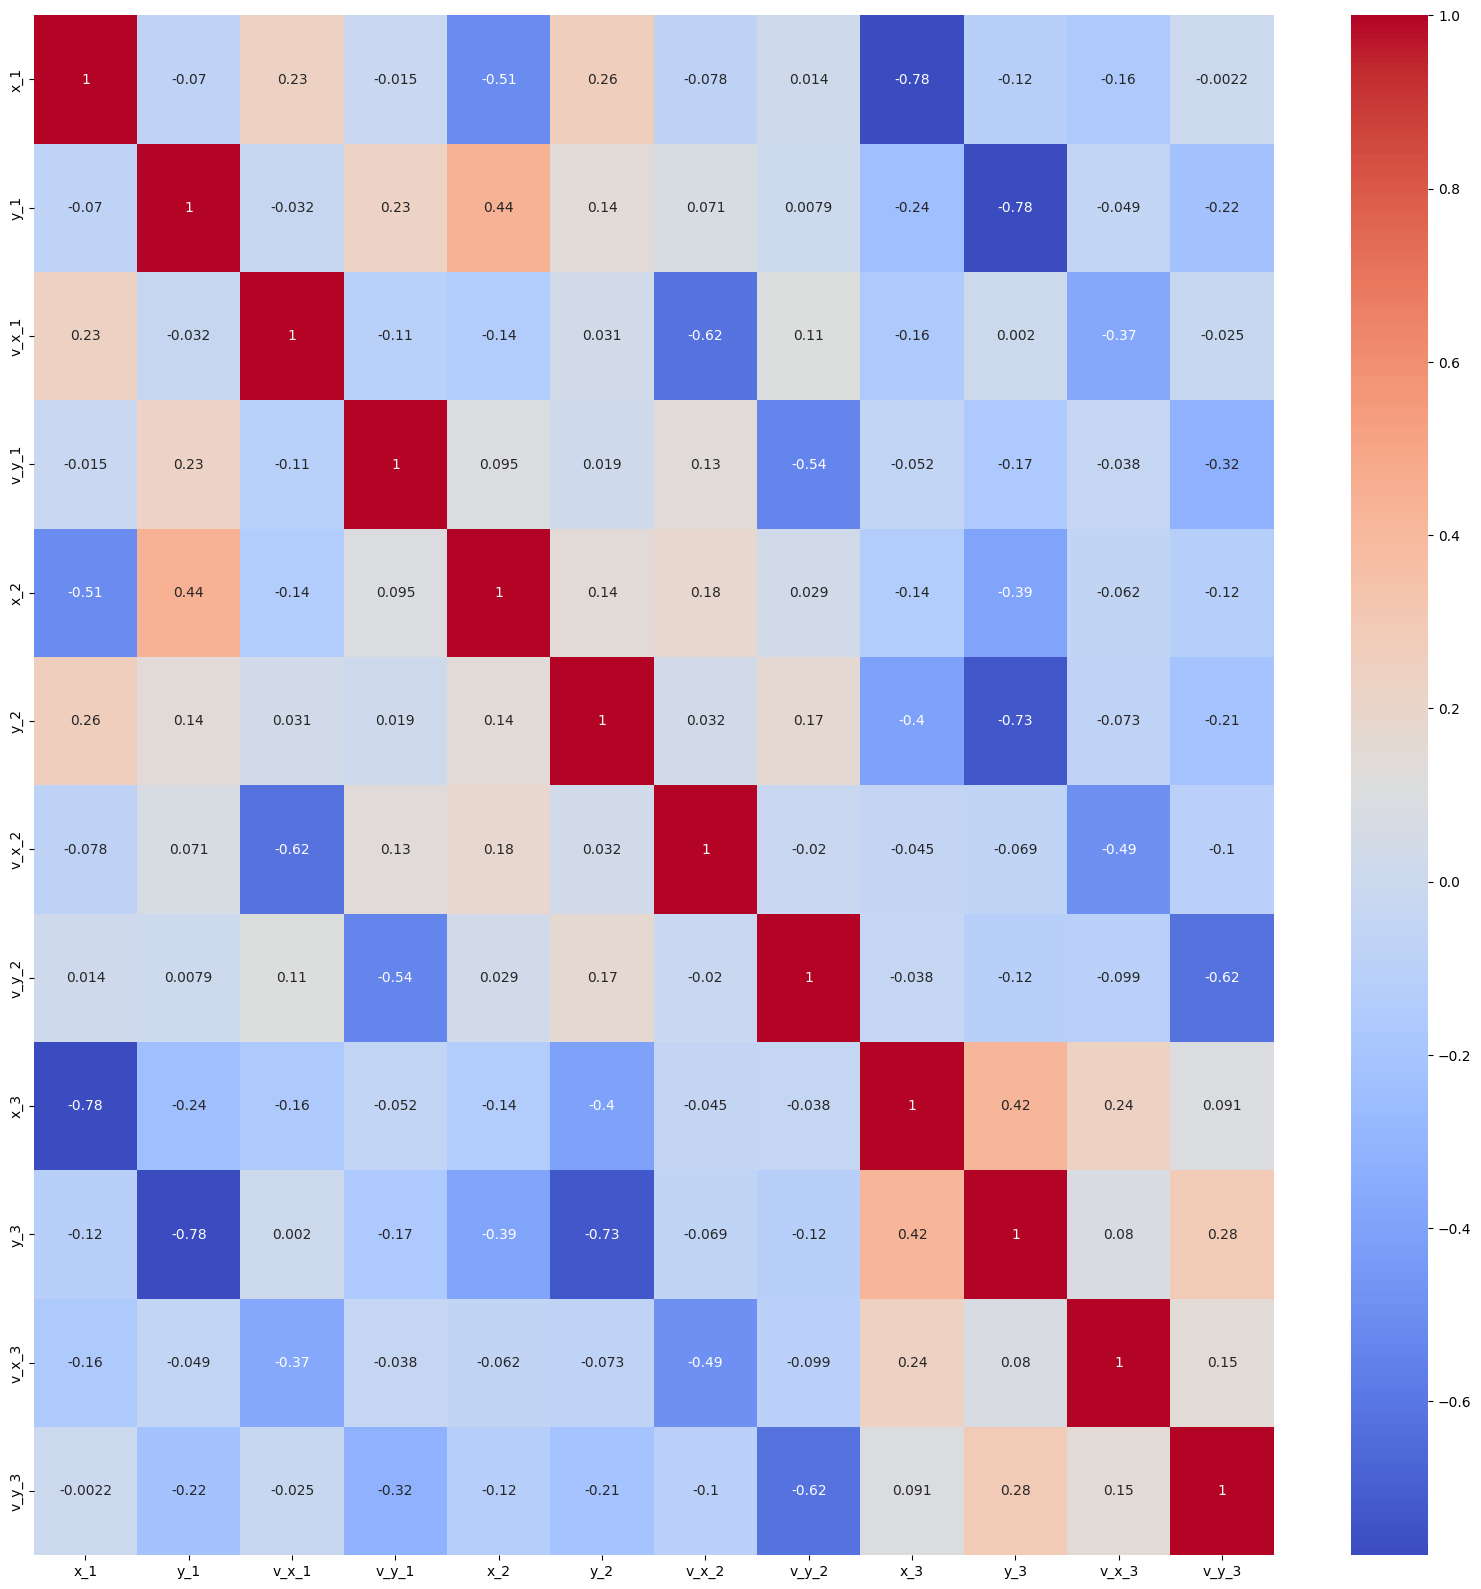

In [42]:
import seaborn as sns

plt.figure(figsize=(20, 20))  # Aumenta o tamanho do gráfico
corr = train_y.corr()
corr = train_y.corr().fillna(0)
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()


In [19]:
X_test_set=pd.read_csv("C:/Users/ptoma/AppData/Roaming/JetBrains/PyCharm2023.3/scratches/X_test.csv")

In [26]:

    
X_test_set = test_set.rename(
        columns={
            "x0_1": "x_1",
            "y0_1": "y_1",
            "x0_2": "x_2",
            "y0_2": "y_2",
            "x0_3": "x_3",
            "y0_3": "y_3",
        }
    ).drop(columns="Id")

X_test_set[["v_x_1", "v_y_1", "v_x_2", "v_y_2", "v_x_3", "v_y_3"]] = 0

print(X_test_set.columns)

Index(['t', 'x_1', 'y_1', 'x_2', 'y_2', 'x_3', 'y_3', 'v_x_1', 'v_y_1',
       'v_x_2', 'v_y_2', 'v_x_3', 'v_y_3'],
      dtype='object')


In [27]:
X_test_features=X_test_set[[
            
            "x_1",
            "y_1",
            "v_x_1",
            "v_y_1",
            "x_2",
            "y_2",
            "v_x_2",
            "v_y_2",
            "x_3",
            "y_3",
            "v_x_3",
            "v_y_3","t"
        ]]

#X_test_features.head()

In [28]:
baseline_predict=baseline.predict(X_test_features)

baseline_predict = pd.DataFrame(baseline_predict, columns=['x_1', 'y_1','v_x_1','v_y_1', 'x_2', 'y_2','v_x_2','v_y_2', 'x_3', 'y_3','v_x_3','v_y_3'])
baseline_predict['Id']=baseline_predict.index

columns=['x_1', 'y_1','x_2', 'y_2','x_3', 'y_3']

baseline_submission = baseline_predict[['Id'] + columns]
baseline_submission.to_csv('baseline-model.csv',index=False)